## Create mutant map from bayesian decoder

In [1]:
from tensorflow import keras
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from neuralgregnet import tools
from neuralgregnet.training import load_model
from tensorflow.keras import backend as K
import scipy.io
from scipy.optimize import curve_fit
import commonFunctions as cf
cmap = plt.get_cmap("Paired")

In [10]:
m=5 # choose which mutant

## Load WT data associated with the mutant ( genotype ==1)

(8, 4, 930)


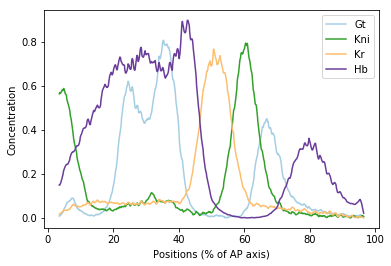

In [11]:
genes=['Gt', 'Kni', 'Kr', 'Hb']
cutNaN=35 # to avoid all the nan values
offNaN=965
positions=np.linspace(0,100,1000)
positions=positions[cutNaN:offNaN]
path="DataPetkova/Data/Gap/"
files=["gap_data_raw_dorsal_wt_osk.mat","gap_data_raw_dorsal_wt_etsl.mat","gap_data_raw_dorsal_wt_bcdE1.mat","gap_data_raw_dorsal_wt_bcd_tsl.mat",
      "gap_data_raw_dorsal_wt_bcd_osk.mat","gap_data_raw_dorsal_wt_bcd_only_germline_clones.mat","gap_data_raw_dorsal_wt_bcd_nos_tsl.mat"]
name=['osk','etsl','bcdE1','bcd-tsl','bcd-osk','bcdGermline','bcd-nos-tsl']
#choose mutant

#load data
wtData,sortAge=cf.loadGG(f=files[m],path=path,positions=positions,ageSort=True,
                         age1=40,age2=44,cutPos=False, genotype=1)
#plot
for i,g in enumerate(genes):
    plt.plot(positions[:], wtData[1,i,:].T,color=cmap(i/4), label=g)
plt.xlabel("Positions (% of AP axis)")
plt.ylabel("Concentration")
plt.legend()

#load autoencoder
aeM= load_model("networks/newWT2")
aeM.compile(optimizer=optimizers.Adam(lr=0.01),loss="mse")

## Load mutant data associated with the mutant ( genotype ==2)

bcdGermline
(9, 4, 930)


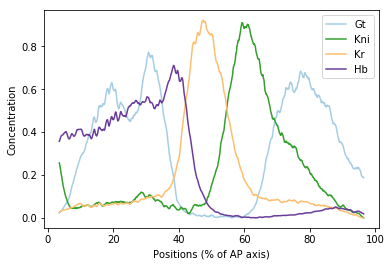

In [13]:
print(name[m])
mutantData,sortAgeM=cf.loadGG(f=files[m],path=path,positions=positions,ageSort=True,
                              age1=40,age2=44,cutPos=False, genotype=2)
#plot
for i,g in enumerate(genes):
    plt.plot(positions[:], mutantData[1,i,:].T,color=cmap(i/4), label=g)
plt.xlabel("Positions (% of AP axis)")
plt.ylabel("Concentration")
plt.legend()

# get manifold of wt( linear or autoencoder)

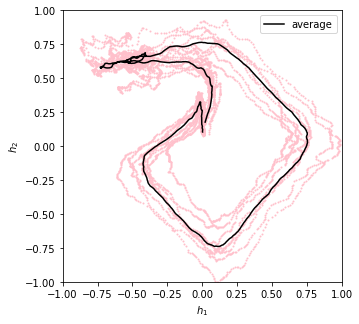

In [14]:
cut=cf.find_nearest(positions,10)
off=cf.find_nearest(positions,90)
h1s,h2s,avg1,avg2=cf.makeManifold(wtData,cut=cut,off=off,linear=True,aeM=aeM)

# bayesian decoder based on wt

In [15]:
#building the bayesian probability function
avg=[avg1,avg2]
hs=np.stack((h1s,h2s),axis=1)
print(hs.shape)

def Phx(h1,h2,p): #p is position index
    #C= np.cov (h1s[:,p], h2s[:,p])
    C=np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            C[i][j]=np.mean([(x[i][p]-avg[i][p])*(x[j][p]-avg[j][p]) for x in hs])
            C[j][i]=C[i][j]
    return np.exp(-chi2(h1,h2,p,C)/2.0)/np.sqrt(np.linalg.det(C)*(2*np.pi)**2)

def chi2(h1,h2,p,C): 
    inverseC=np.linalg.inv(C)
    return (((h1-avg1[p])*inverseC[0,0]*(h1-avg1[p])) +
            ((h1-avg1[p])*inverseC[0,1]*(h2-avg2[p]))+
            ((h2-avg2[p])*inverseC[1,0]*(h1-avg1[p])) +
            ((h2-avg2[p])*inverseC[1,1]*(h2-avg2[p])))


#test
print(Phx(h1s[0,200], h2s[0,200], 200))#middle
print(Phx(avg1[200], avg2[200], 200))#higest
print(Phx(h1s[0,300], h2s[0,300], 200))#lowest

Px=1/(off-cut)
def Zfunc(h1,h2):
    sum=0
    for p in range(len(avg1)):
        sum+= Phx(h1,h2,p)*Px
    return sum

def Pxh(x,h1,h2,Z):# x is position
    p=cf.find_nearest(positions[cut:off],x)
    return (Phx(h1,h2,p)*Px)/Z

def gauss(x,x0,sig,a):  #use to fit later
    return a*np.exp(-(x-x0)**2/(2*sig**2))

(8, 2, 799)
38.54082442523498
38.992887057871165
36.803939552550254


In [14]:
#map for one embryo
embryo=1
get_middle_layer_output = K.function([aeM.layers[0].input],[aeM.layers[1].output])
p=np.linspace(0, off-cut-1 ,off-cut)
pos=[positions[cut+int(x)] for x in p]
prob=[]# probability of being a position (2d array). This is the map.
for x in p:
    print(x)
    x=int(x)
    row=[]
    #get hidden nodes of mutant data for position x
    inp=mutantData[embryo,:,cut+x].reshape((1,4))
    layer_output = get_middle_layer_output([inp])[0][0]
    #normalization
    Z=Zfunc(layer_output[0],layer_output[1])
    for y in p:#iterate through all the possible position x* 
        y=int(y)
        row.append(Pxh(positions[cut:off][y], layer_output[0],layer_output[1],Z)) # calculate the probability of being at the position x*
   
    prob.append(row)
    
prob=np.array(prob)


conf=plt.contourf(pos,pos,prob.T,cmap='jet')
plt.colorbar(conf)
plt.xlabel("x")
plt.ylabel("x*")

25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0


KeyboardInterrupt: 

0
1
2
3
4
5
6
7
8
mean std of localized fit
nan
mean(over embryos) of median(over x) std of distributions
nan


/Users/juliette/Documents/Biophysics/gapgenes_autoencoder/commonFunctions.py:291: RuntimeWarning: Mean of empty slice
  print(np.nanmean(std))
/Users/juliette/Documents/Biophysics/gapgenes_autoencoder/commonFunctions.py:293: RuntimeWarning: Mean of empty slice
  print(np.nanmean(sig))


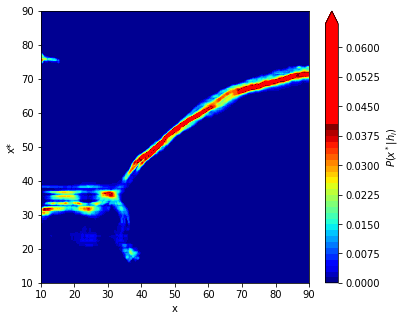

In [16]:
prob,std,sig=cf.makeAvgMap(mutantData,Pxh,Zfunc,linear=True,meanErr=False, medianErr=False,cut=cut,off=off)

In [17]:
#np.save("useful/linear/bcdGermline.npy",prob)

In [ ]:
#prob=np.load("useful/linear/osk.npy")
plt.figure(figsize=(6,5))
p=np.linspace(0, off-cut-1 ,off-cut)
pos=[positions[cut+int(x)] for x in p]
conf=plt.contourf(pos,pos,prob.T, 50,cmap='jet', extend='max',vmax=0.04)
conf.cmap.set_over("red")
cb1=plt.colorbar(conf)
cb1.ax.set_ylabel(r"$P(x^*|{h_i})$")
plt.xlabel("x")
plt.ylabel("x*")

## Reproduce directly from 4 gg

In [ ]:
#calculate average gap gene (useful for covariant matrix)
avg1=np.mean(wtData[:,0,cut:off],axis=0)
avg2=np.mean(wtData[:,1,cut:off],axis=0)
avg3=np.mean(wtData[:,2,cut:off],axis=0)
avg4=np.mean(wtData[:,3,cut:off],axis=0)
avg=np.stack((avg1,avg2,avg3,avg4))
print(avg4.shape,avg.shape)

In [ ]:
#petkova's method

def Phx4(g1,g2,g3,g4,p): #p is position index
    #C= np.cov (np.stack((wtData[:,0,p], wtData[:,1,p],wtData[:,2,p],wtData[:,3,p]),axis=0))         
    #"""
    C=np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            C[i][j]=np.mean([(x[i][p]-avg[i][p])*(x[j][p]-avg[j][p]) for x in wtData])
            C[j][i]=C[i][j]
    #"""
    return np.exp(-chi24(g1,g2,g3,g4,p,C)/2.0)/np.sqrt(np.linalg.det(C)*(2*np.pi)**4)

def chi24(g1,g2,g3,g4,p,C):#chi square
    inverseC=np.linalg.inv(C)
    g=[g1,g2,g3,g4]
    chi=0
    for i in range(4):
        for j in range(4):
            chi+=(g[i]-avg[i][p])*inverseC[i][j]*(g[j]-avg[j][p])
    return chi
    
print(Phx4(wtData[0,0,200], wtData[0,1,200],wtData[0,2,200],wtData[0,3,200], 200))
print(Phx4(avg1[200], avg2[200],avg3[200],avg4[200], 200))
print(Phx4(wtData[0,0,300], wtData[0,1,300],wtData[0,2,300],wtData[0,3,300], 200))

Px=1/(off-cut)
def Zfunc4(g1,g2,g3,g4):
    sum=0
    for p in range(len(avg1)):
        sum+= Phx4(g1,g2,g3,g4,p)*Px
    return sum

def Pxh4(x,g1,g2,g3,g4,Z):
    p=cf.find_nearest(positions[cut:off],x)
    return (Phx4(g1,g2,g3,g4,p)*Px)/Z

def gauss(x,x0,sig,a):
    return a*np.exp(-(x-x0)**2/(2*sig**2))

In [ ]:
p=np.linspace(0, off-cut-1 ,off-cut)
pos=[positions[cut+int(x)] for x in p]
prob=[]# 2d array of average probability of being a position. This is the prediction map.
sig=[] #collecting the allSig for all embryos
std=[]# collecting the allStd for all embryos
allMaps=[] # collecting the allRows for all embryos. arrays for maps for each embryo.
#iterate through all embryos
for emb in range(mutantData.shape[0]):
    print(emb)
    allStd=[]#all std of fits
    allSig=[]# all median sigma
    allRow=[]# all rows of prediction along x*
    #iterate through all positions along AP axis x
    for x in p:
        x=int(x)
        row=[]
        #for normalization
        inp=mutantData[emb,:,cut+int(x)]
        Z=Zfunc4(inp[0],inp[1],inp[2],inp[3])
        #iterate through all possible position x*
        for y in p:
            y=int(y)
            row.append(Pxh4(positions[cut:off][y], inp[0],inp[1],inp[2],inp[3],Z))
        allRow.append(row)
        #calculating positional error with fit like figure S5 of Petkova
        try:
            argmax=np.argmax(row)
            #loacalized fit
            if argmax<40:
                width=argmax
            else:
                width=40
             #edge case
            if argmax<3:
                popt,pcov = curve_fit(gauss,pos[:40],row[:40], p0=[pos[argmax],0.5, 1/(np.sqrt(2*np.pi*1**2))])
            else:
                popt,pcov = curve_fit(gauss,pos[argmax-width:argmax+width],row[argmax-width:argmax+width], p0=[pos[argmax],0.5, 1/(np.sqrt(2*np.pi*1**2))])

        except RuntimeError:
            popt=[np.nan,np.nan]
            print("Error - curve_fit failed")
        #if fit failed
        if (pcov[0,0] == np.nan) or (pcov[1,1] == np.nan)  or (pcov[1,1] >100) or (pcov[0,0]>100):
            allStd.append(np.nan )
        else:    
            allStd.append(abs(popt[1]))
        # other mesure of precision like  figure S1i
        #median sigma
        mu=np.sum([row[i]*pos[i] for i in range(len(pos))])
        sigma=np.sqrt(np.sum([((pos[i]-mu)**2) * row[i] for i in range(len(pos))]))
        allSig.append(sigma)

    allStd=np.array(allStd)
    std.append(np.nanmean(allStd))

    allSig=np.array(allSig)
    sig.append(np.nanmedian(allSig))

    allMaps.append(allRow)
#average all maps    
prob=np.mean(allMaps,axis=0)

print("mean std of localized fit")
print(np.nanmean(std))
print("mean(over embryos) of median(over x) std of distributions")
print(np.nanmean(sig))
#plot map
plt.figure(figsize=(6,5))
conf=plt.contourf(pos,pos,prob.T, 50,cmap='jet', extend='max',vmax=0.04)#CAREFUL prob needs to be transposed
conf.cmap.set_over("red")
cb1=plt.colorbar(conf)
cb1.ax.set_ylabel(r"$P(x^*|{g_i})$")
plt.xlabel("x")
plt.ylabel("x*")